In [73]:
import pyprob
from pyprob import Model
from pyprob.distributions import Normal, Uniform, Categorical

import torch
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

# Concept

In [33]:
class Concept:
    
    def __init__(self, mult, params):
        """
        :param mult: boolean flag that is True if concept is multiple, False if concept is range
        :param params: list of params - [mult] if multiple concept, [start, end] if range concept
        """
        self.mult = mult
        self.params = params
        self._numbers = self._populate_numbers()
    
    
    def _populate_numbers(self):
        """
        Fill in the number set for the concept
        """
        if self.mult:
            if (self.params[0] < 0) or (self.params[0] > 100):
                raise Exception('Invalid multiple for concept.')
            
            if not isinstance(self.params[0], int):
                raise Exception('Multiple must be an integer.')
                
            numbers = np.arange(self.params[0], 101, self.params[0])
            return numbers
        else:
            start, end = self.params[0], self.params[1]
            
            if (start < 0) or (end > 100) or (start > end):
                raise Exception('Invalid interval for concept.')
            
            if not (isinstance(start, int) and isinstance(end, int)):
                raise Exception('Start and end must be integers.')
                
            numbers = np.arange(start, end+1)
            return numbers
        
        
    def sample(self, num_samples):
        """
        Sample num_samples observations from the concept
        """
        samples = []

        for i in range(num_samples):
            sample = random.choice(self.numbers)
            samples.append(sample)

        return samples
    
    
    def __repr__(self):
        if self.mult:
            return 'Multiples of {}: {}'.format(self.params[0], self.numbers)
        else:
            return 'Range [{}, {}]: {}'.format(self.params[0], self.params[1], self.numbers)
    
    
    @property
    def numbers(self):
        return self._numbers

# Generative model

In [101]:
class NumberGame(Model):
    
    def __init__(self, mult_range_start, mult_range_end, interval_range_length):
        super().__init__(name='Number game')
        self.mult_range_start = mult_range_start
        self.mult_range_end = mult_range_end
        self.interval_range_length = interval_range_length
#         self.prior_mean = 1
#         self.prior_std = math.sqrt(5)
#         self.likelihood_std = math.sqrt(2)
        
    
    def _generate_multiple_concept(self, multiple):
        """
        Generates a set of all multiples of multiple from [1,... , 100]
        :param multiple: integer from [1, 100]
        """
        mult_concept = Concept(True, [multiple])
        return mult_concept
    
    
    def _generate_range_concept(self, start, end):
        """
        Generates a set of numbers from [start, ..., end] inclusive
        """
        range_concept = Concept(False, [start, end])
        return range_concept
    
    
    def generate_all_concepts(self):
        """
        Generate a set of all concepts as specified by parameters
        :param mult_range_start: integer with smallest mult considered
        :param mult_range_end: integer with largest mult considered
        :param interval_range_length: length of ranges being considered
        """
        concepts = []
        
        for multiple in range(self.mult_range_start, self.mult_range_end + 1):
            mult_concept = self._generate_multiple_concept(multiple)
            concepts.append(mult_concept)
            
        i = 1
        while i + self.interval_range_length <= 100:
            range_concept = self._generate_range_concept(i, i + self.interval_range_length)
            concepts.append(range_concept)
            i += 1
        
        return concepts

    
    def forward(self):
        """
        Generative sampling process
        """
        concepts = self.generate_all_concepts()
        
        # sample the (latent) mean variable to be inferred
        concept = random.choice(concepts)
        print(concept)
            
        # define the likelihood
        likelihood = Categorical(torch.tensor(np.ones(len(concepts))))
        print(likelihood)

        # Lets add two observed variables
        # -> the 'name' argument is used later to assignment values:
        pyprob.observe(likelihood, name='obs1') # NOTE: observe -> denotes observable variables
        pyprob.observe(likelihood, name='obs2')
        pyprob.observe(likelihood, name='obs3')

        # return the latent quantity of interest
        return concept
    
model = NumberGame(mult_range_start=2, mult_range_end=10, interval_range_length=10)

In [102]:
model.forward()

Range [72, 82]: [72 73 74 75 76 77 78 79 80 81 82]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))


Range [72, 82]: [72 73 74 75 76 77 78 79 80 81 82]

In [98]:
prior = model.prior_results(num_traces=1000)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
Range [16, 26]: [16 17 18 19 20 21 22 23 24 25 26]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.010

Multiples of 8: [ 8 16 24 32 40 48 56 64 72 80 88 96]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [58, 68]: [58 59 60 

Range [55, 65]: [55 56 57 58 59 60 61 62 63 64 65]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [44, 54]: [44 45 46 47 

Range [26, 36]: [26 27 28 29 30 31 32 33 34 35 36]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Multiples of 4: [  4   8  12 

Range [30, 40]: [30 31 32 33 34 35 36 37 38 39 40]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [22, 32]: [22 23 24 25 

Range [47, 57]: [47 48 49 50 51 52 53 54 55 56 57]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [69, 79]: [69 70 71 72 

Range [28, 38]: [28 29 30 31 32 33 34 35 36 37 38]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [69, 79]: [69 70 71 72 

Range [63, 73]: [63 64 65 66 67 68 69 70 71 72 73]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [12, 22]: [12 13 14 15 

Range [64, 74]: [64 65 66 67 68 69 70 71 72 73 74]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [60, 70]: [60 61 62 63 

Range [57, 67]: [57 58 59 60 61 62 63 64 65 66 67]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [7, 17]: [ 7  8  9 10 1

Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [84, 94]: [84 85 86 87 88 89 90 91 92 93 94]
Categorical(num_categories: 9

Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [73, 83]: [73 74 75 76 77 78 79 80 81 82 83]
Categorical(num_categories: 9

Range [6, 16]: [ 6  7  8  9 10 11 12 13 14 15 16]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [72, 82]: [72 73 74 75 7

Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [84, 94]: [84 85 86 87 88 89 90 91 92 93 94]
Categorical(num_categories: 9

Range [10, 20]: [10 11 12 13 14 15 16 17 18 19 20]  539/1000 | 536.93       
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Ran

Range [80, 90]: [80 81 82 83 84 85 86 87 88 89 90]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [64, 74]: [64 65 66 67 

Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [73, 83]: [73 74 75 76 77 78 79 80 81 82 83]
Categorical(num_categories: 9

Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Multiples of 9: [ 9 18 27 36 45 54 63 72 81 90 99]
Categorical(num_categories: 9

Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [10, 20]: [10 11 12 13 14 15 16 17 18 19 20]
Categorical(num_categories: 9

Multiples of 7: [ 7 14 21 28 35 42 49 56 63 70 77 84 91 98]0 | 531.88       
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Ran

Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [67, 77]: [67 68 69 70 71 72 73 74 75 76 77]
Categorical(num_categories: 9

Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [37, 47]: [37 38 39 40 41 42 43 44 45 46 47]
Categorical(num_categories: 9

Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [46, 56]: [46 47 48 49 50 51 52 53 54 55 56]
Categorical(num_categories: 9

Range [84, 94]: [84 85 86 87 88 89 90 91 92 93 94]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [67, 77]: [67 68 69 70 

Range [46, 56]: [46 47 48 49 50 51 52 53 54 55 56]  789/1000 | 524.54       
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Ran

Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [42, 52]: [42 43 44 45 46 47 48 49 50 51 52]
Categorical(num_categories: 9

Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [75, 85]: [75 76 77 78 79 80 81 82 83 84 85]
Categorical(num_categories: 9

Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [58, 68]: [58 59 60 61 62 63 64 65 66 67 68]
Categorical(num_categories: 9

Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [45, 55]: [45 46 47 48 49 50 51 52 53 54 55]
Categorical(num_categories: 9

Range [76, 86]: [76 77 78 79 80 81 82 83 84 85 86]  881/1000 | 501.98       
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Ran

Range [54, 64]: [54 55 56 57 58 59 60 61 62 63 64]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [2, 12]: [ 2  3  4  5  

Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [15, 25]: [15 16 17 18 19 20 21 22 23 24 25]
Categorical(num_categories: 9

Range [71, 81]: [71 72 73 74 75 76 77 78 79 80 81]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [45, 55]: [45 46 47 48 

Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Range [2, 12]: [ 2  3  4  5  6  7  8  9 10 11 12]
Categorical(num_categories: 99

Range [71, 81]: [71 72 73 74 75 76 77 78 79 80 81]  973/1000 | 484.73       
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))
Ran

Multiples of 5: [  5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90
  95 100]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,

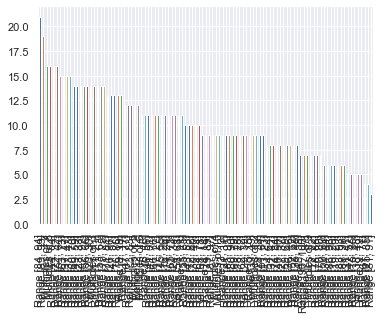

In [99]:
def simple_concept(concept):
    name = str(concept)
    return name.split(':')[0]

pd.Series(map(simple_concept, prior.get_values())).value_counts().plot('bar')

In [100]:
posterior = model.posterior_results(
                    num_traces=10, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                    observe={'obs1': 30, 'obs2': 20, 'obs3': 90} # assign values to the observed values
                                         )

Time spent  | Time remain.| Progress             | Trace | Traces/sec
Range [23, 33]: [23 24 25 26 27 28 29 30 31 32 33]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0

Range [51, 61]: [51 52 53 54 55 56 57 58 59 60 61]
Categorical(num_categories: 99, probs:tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
        0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101]))



In [103]:
posterior.mean

TypeError: unsupported operand type(s) for +: 'int' and 'Concept'